# **Елисеев Арсений Алексеевич, ПИ21-1м**
## Линейный классификатор Softmax 

Для выполнения этого задания нужно будет дописать код в этом ноутбуке  

В этом упражнении Вам предстоит:

- реализовать функцию потерь (**loss**) для Softmax классификатора
- реализовать векторизованную функцию для вычисления **аналитического градиента**
- **оптимизировать** матрицу весов W с помощью стохастического градиентного спуска **SGD**
- найти лучшие гиперпараметры **learning rate и regularization** 
- **визуализировать** матрицу оптимальных весов.

In [ ]:
#Импорт библиотек
import time
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from itertools import product
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

# Загрузка датасета CIFAR-10 и предварительная подготовка

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

#Проверим размер входных и выходных векторов.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print()

170498071/170498071 [==============================] - 2s 0us/step
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)



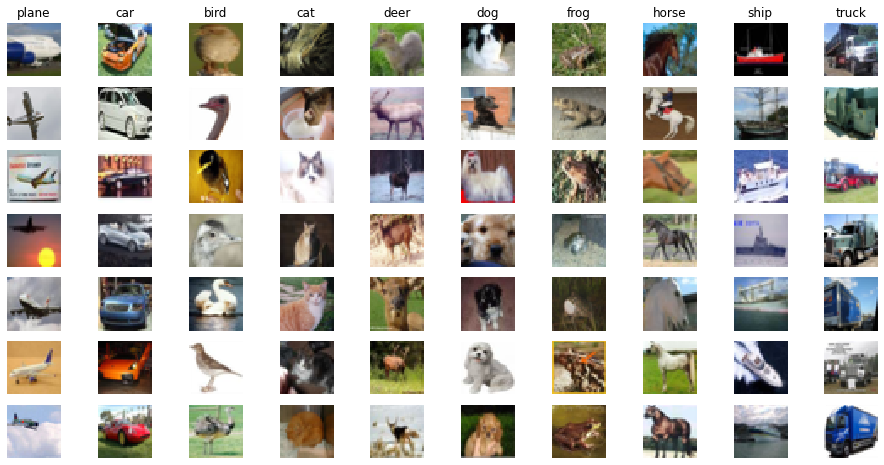

In [ ]:
#Перед началом работы полезно посмотреть на данные.
#Отобразим пример из каждого класса.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
#Для удобства преобразуем двумерные изображения в одномерные вектора fp64
X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype(np.float64)
X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype(np.float64)
y_train = y_train.flatten()
y_test = y_test.flatten()
#Проверим размер полученных данных
print('Training data shape: ', X_train.shape)
print('Test data shape: ', X_test.shape)
print('Training label shape: ', y_train.shape)
print('Test label shape: ', y_test.shape)

Training data shape:  (50000, 3072)
Test data shape:  (10000, 3072)
Training label shape:  (50000,)
Test label shape:  (10000,)


[130.71074 136.05614 132.5538  130.14036 135.44238 131.85358 131.05044
 136.24616 132.58144 131.56886]


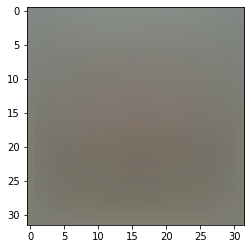

In [ ]:
#Нормализуем значения яркости пикселей 
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 

#визуализируем среднюю яркость
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()

In [ ]:
#Вычтем средние значения яркости
X_train -= mean_image
X_test -= mean_image

#Добавим к вектору исходных данных фиктивный признак с постоянным значением 1.
#Этот трюк позволит избежать лишних вычислений: x @ W + b  => x' @ W'
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print(X_train.shape, X_test.shape)

(50000, 3073) (10000, 3073)


## Softmax Classifier


In [ ]:
#Небольшая фишка с итерацией по заданному измерению ndarray
p = np.arange(40).reshape(4, 10)
y = 1, 2, 3, 4

print('p = \n', p)
print('y = \n', y)

p = 
 [[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]]
y = 
 (1, 2, 3, 4)


In [ ]:
#Возьмем первый элемент из нулевой строки, второй элемент из первой строки и так далее.
p[range(4), y]

array([ 1, 12, 23, 34])

In [ ]:
#Реализуйте эффективную векторизованную  
#функцию вычисления loss и dW

def softmax_loss(W, X, y, reg):
    """
    Softmax loss function, vectorized version.
    Inputs and outputs are the same as softmax_loss_naive.
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    #Loss-функция
    N = X.shape[0]
    z = X @ W
    z -= z.max()
    exps = np.exp(z)
    s = exps / exps.sum(axis = 1, keepdims = True)
    loss = -np.log(s[range(N), y]).mean()
    
    #Расчёт градиента
    s[range(N), y] -= 1
    dL_dz = s
    dW = X.T @ dL_dz

    #регулярязация
    loss += reg * np.linalg.norm(W)
    dW += 2 * reg * W

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return loss, dW/N

In [ ]:
# Инициализируем веса значениями близкими, но не равными нулю
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss(W, X_test, y_test, 0.0)

# Обязательно проверим правильность реализации функции
# Для 10 классов loss должен быть около -log(0.1).
print('loss: %f' % loss)
print('Начальное значение Loss = %f' % (-np.log(0.1)))

loss: 2.400872
Начальное значение Loss = 2.302585


**Вопрос 1**

Объясните, почему мы предположили, что для 10 классов при весах близких к нулю
 softmax loss приблизительно равен -log(0.1)?  
  
$\color{blue}{\textit Ответ:}$ *Так как веса близки к 0, то и оценки S (для каждого класса) = 0. Числитель дроби = 1. Знаменатель = 10 (так как всего 10 классов). Получется, что под логарифмом будет 0.1*


# Стохастический градиентный спуск

In [ ]:
# Реализуйте SGD и проверьте результат 

class SoftmaxClassifier():
    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1, num_iters=100,
              batch_size=32, verbose=True):
        """
        Обучение классификатора с помощью стохастического градиентного спуска
        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.
        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None
            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (batch_size, dim)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            indeces = np.random.choice(num_train, size=batch_size)
            X_batch = X[indeces]
            y_batch = y[indeces]
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # evaluate loss and gradient
            loss,  grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            self.W -= learning_rate * grad
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f '  % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.
        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[0])
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method. Store the predicted labels in y_pred.            #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        z = X @ self.W
        y_pred = np.argmax(z, axis=-1)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.
        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        return softmax_loss(self.W, X_batch, y_batch, reg)

In [ ]:
softmax_cls = SoftmaxClassifier()
tic = time.time()
loss_hist = softmax_cls.train(
    X_train[:1000], y_train[:1000], 
    learning_rate=1e-4, reg=1e-3,
    num_iters=1000, verbose=True)

toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1000: loss 6.332308 
iteration 100 / 1000: loss 15.458462 
iteration 200 / 1000: loss 29.413496 
iteration 300 / 1000: loss 22.933749 
iteration 400 / 1000: loss 18.477909 
iteration 500 / 1000: loss 8.358230 
iteration 600 / 1000: loss 3.956233 
iteration 700 / 1000: loss 2.547955 
iteration 800 / 1000: loss 6.310405 
iteration 900 / 1000: loss 1.508639 
That took 1.379317s


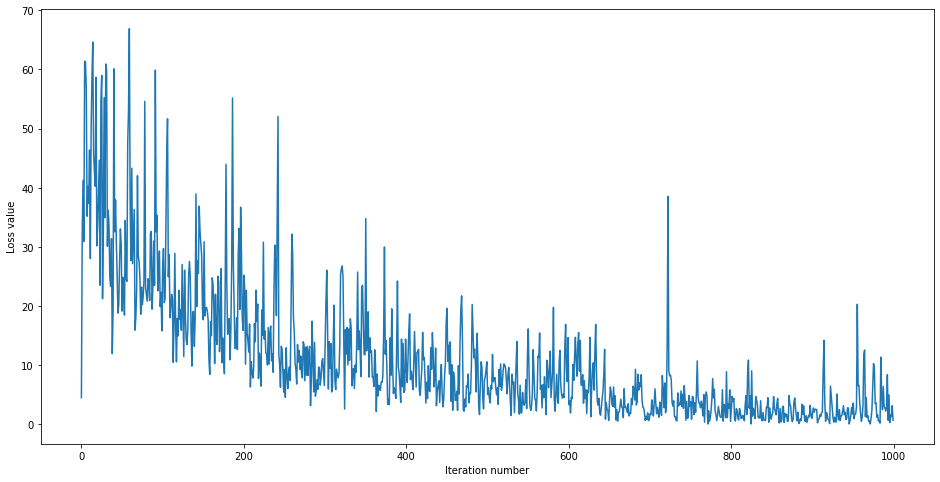

In [ ]:
#Построим график зависимости loss от количества итераций
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
#Оцените точность предсказания на выборках train и val
y_train_pred = softmax_cls.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred) ))
y_test_pred = softmax_cls.predict(X_test)
print('validation accuracy: %f' % (np.mean(y_test == y_test_pred) ))

training accuracy: 0.286220
validation accuracy: 0.275600


# Поиск лучших гиперпараметров

In [ ]:
# Используйте валидационную выборку для выбора лучших гиперпараметров 
# (learning rate and regularization strength)
# Добейтесь точности не меньше 0.38 на выборке test.
# Используйте словарь results в котором 
# ключи - кортеж  (learning_rate, regularization_strength)
# значения - (training_accuracy, validation_accuracy)
# Точность вычисляется как отношение числа верно предсказанных классов 
# к объему выборки
results = {}
best_val = -1   
best_softmax = None #Лучший экземпляр Softmax classifier 

################################################################################
# TODO:                                                                        #
# Напишите код, позволяющий найти лучшее значение гиперпараметров на val       #
# выборке. Для каждой комбинации гиперпараметров обучите классификатор         #
# на train выборке, вычислите точность на выборках train, val и сохраните      #
# результат в словарь results. Лучшее значение точности сохраните в best_val   #
# лучший классификатор - в best_softmax                                        #
#                                                                              #
################################################################################

# Пример списка допустимых значений. Можете изменить на свое усмотрение.
regularization_strengths = np.logspace(-1, 1, 15) #набор коэффициентов регуляризации
learning_rates = [1e-7, 5e-5]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr, reg in product(learning_rates, regularization_strengths):

  #Обучение модели
  softmax_cls = SoftmaxClassifier() 
  loss_hist = softmax_cls.train(
    X_train, y_train, 
    learning_rate=lr, reg=reg, batch_size=5,
    num_iters=4000, verbose=False)
  
  #Результаты работы на обучающем периоде:
  y_train_pred = softmax_cls.predict(X_train)
  train_accuracy = np.mean(y_train == y_train_pred)

  #Результаты работы на валидационном периоде:
  y_val_pred = softmax_cls.predict(X_val)
  val_accuracy = np.mean(y_val == y_val_pred)

  results[(lr, reg)] = (train_accuracy, val_accuracy)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
#Вывод результатов
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]

    #Фиксация лучшей точности:
    if val_accuracy>best_val:
      best_val = val_accuracy

    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 1.000000e-01 train accuracy: 1.000000 val accuracy: 0.125000
lr 1.000000e-07 reg 1.389495e-01 train accuracy: 1.000000 val accuracy: 0.125000
lr 1.000000e-07 reg 1.930698e-01 train accuracy: 1.000000 val accuracy: 0.250000
lr 1.000000e-07 reg 2.682696e-01 train accuracy: 1.000000 val accuracy: 0.125000
lr 1.000000e-07 reg 3.727594e-01 train accuracy: 1.000000 val accuracy: 0.125000
lr 1.000000e-07 reg 5.179475e-01 train accuracy: 1.000000 val accuracy: 0.000000
lr 1.000000e-07 reg 7.196857e-01 train accuracy: 1.000000 val accuracy: 0.000000
lr 1.000000e-07 reg 1.000000e+00 train accuracy: 1.000000 val accuracy: 0.000000
lr 1.000000e-07 reg 1.389495e+00 train accuracy: 1.000000 val accuracy: 0.000000
lr 1.000000e-07 reg 1.930698e+00 train accuracy: 1.000000 val accuracy: 0.250000
lr 1.000000e-07 reg 2.682696e+00 train accuracy: 1.000000 val accuracy: 0.500000
lr 1.000000e-07 reg 3.727594e+00 train accuracy: 1.000000 val accuracy: 0.125000
lr 1.000000e-07 reg 5.179475

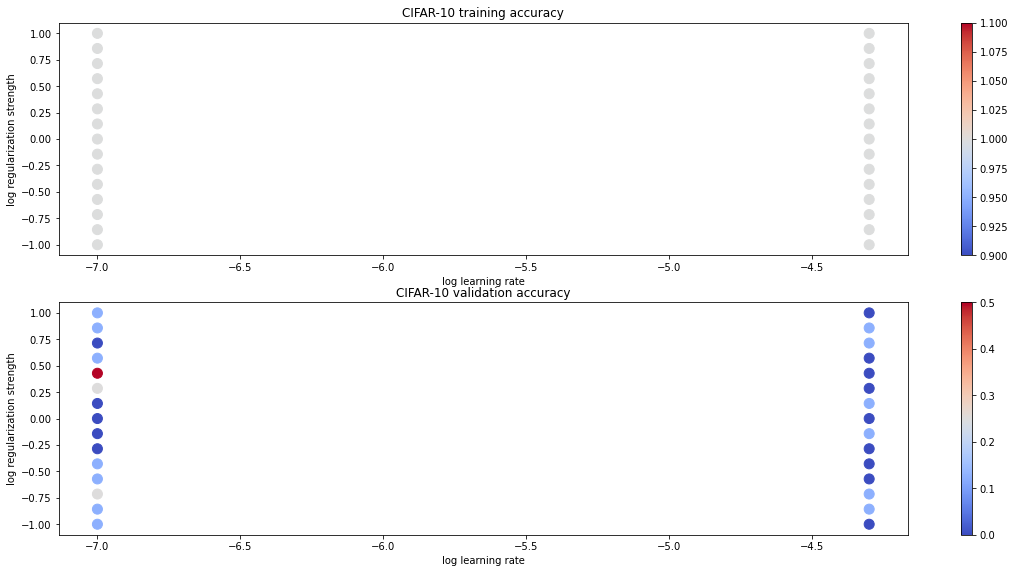

In [ ]:
# Визуализируем результаты кросс-валидации
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# график accuracy на обучении
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# график accuracy на валидации
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

# Точность на test выборке


In [ ]:
y_test_pred = softmax_cls.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.169100


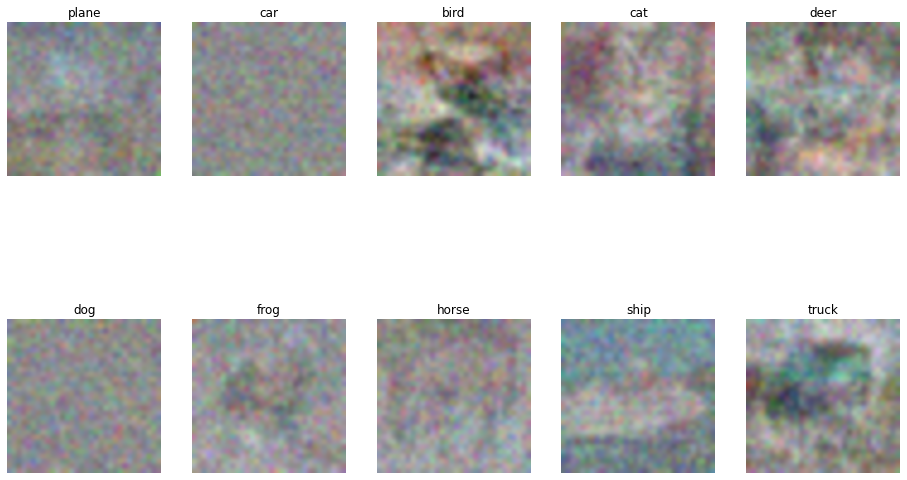

In [ ]:
# Визуализируем веса W для каждого класса
w = softmax_cls.W[:-1,:] # отбросим фиктивное измерение bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(16, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Масштабируем веса в значения от 0 до 255 для визуализации
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'), interpolation='quadric')
    plt.axis('off')
    plt.title(classes[i])

Не забудьте сохранить этот ноутбук со всеми выводами из ячеек и отправить на почту ailabintsev@fa.ru